# **Course:** ITAI 2277 - Data Science in Artificial Intelligence
# **Professor:** Sitaram Ayyagari
# **Student:** Adejare Fasiku - W215804390
# **Term:** Fall 2025 - CR: 14165
# **Capstone Project:** House Price and Quality Prediction






In [66]:
# import os

# # Install desired versions, letting pip resolve common dependencies.
# # Explicitly set versions for other critical libraries, but allow pandas/numpy flexibility where possible for google.colab.
# !pip -q install --upgrade pip

# !pip install --upgrade pandas numpy scikit-learn matplotlib seaborn joblib ipywidgets


# # Ensure output directories are created. This was previously in cell `oo_l2poR55ls`, moved here for earlier setup.
# import warnings
# warnings.filterwarnings("ignore")
# from pathlib import Path
# DATA_DIR = Path(os.getcwd())  # change if your CSVs are in another folder
# OUTPUT_DIR = Path("./outputs")
# PLOTS_DIR = OUTPUT_DIR / "plots"
# MODELS_DIR = OUTPUT_DIR / "models"
# for d in (OUTPUT_DIR, PLOTS_DIR, MODELS_DIR):
#     d.mkdir(parents=True, exist_ok=True)

In [67]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Display settings for DataFrame(df)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)



#########
# In this step we import all required libraries and set up global paths and options.

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from datetime import datetime

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Create output directories
DATA_DIR = Path(os.getcwd())  # change if your CSVs are in another folder
OUTPUT_DIR = Path("./outputs")
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
for d in (OUTPUT_DIR, PLOTS_DIR, MODELS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# 🚀 Step **1️** - Load dataframe(df), Dataframe exploration, Clean dataframe

In [68]:
# --- Step 1: Load the data ---
# We load train.csv and test.csv. If test.csv isn't used for model evaluation here (no SalePrice),
# we'll still load it to show how to prepare a submission later if needed.

print("Loading data...")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"

if not TRAIN_PATH.exists():
    raise FileNotFoundError(f"train.csv not found at {TRAIN_PATH}. Place train.csv there or change DATA_DIR.")

train = pd.read_csv(TRAIN_PATH)
print(f"Train shape: {train.shape}")

if TEST_PATH.exists():
    test = pd.read_csv(TEST_PATH)
    print(f"Test shape: {test.shape}")
else:
    test = None
    print("No test.csv found at path; continuing without it.")


Loading data...
Train shape: (1460, 81)
Test shape: (1459, 80)


# 🚀 Step **2️** - Initial EDA and description

Show basic info, head, and target distribution. Save key plots.


=== Quick EDA ===
   Id  SalePrice
0   1     208500
1   2     181500
2   3     223500
3   4     140000
4   5     250000

Data types:
object     43
int64      35
float64     3
Name: count, dtype: int64

Missing values (top 20):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

Basic stats for numeric features:
               count          mean          std     min     50%       max
Id            1460.0    730.500000   421.610009     1.0   730.5    1460.0
MSSubClass    1460.0     56.897260    42.300571    20.0    50.0     190.0
LotFrontage   1201.0     70.049958    24.284752    21.0    69.0     313.0
LotArea 

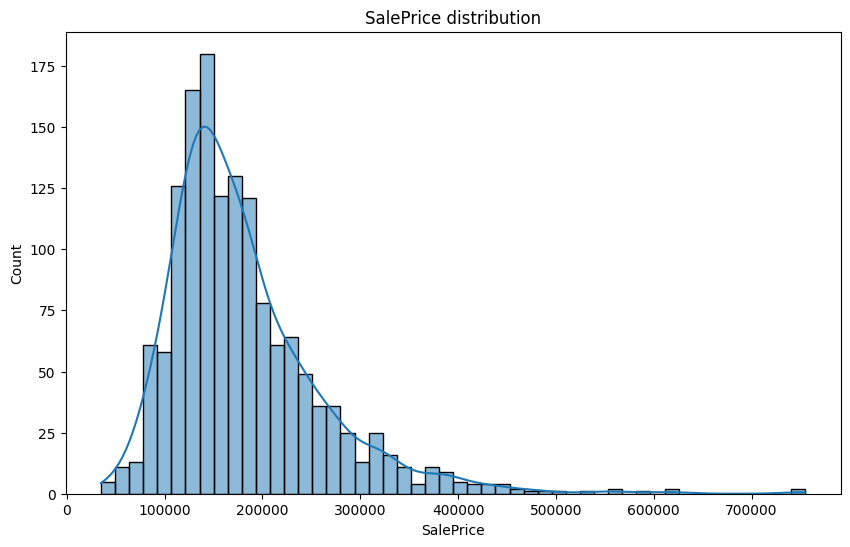

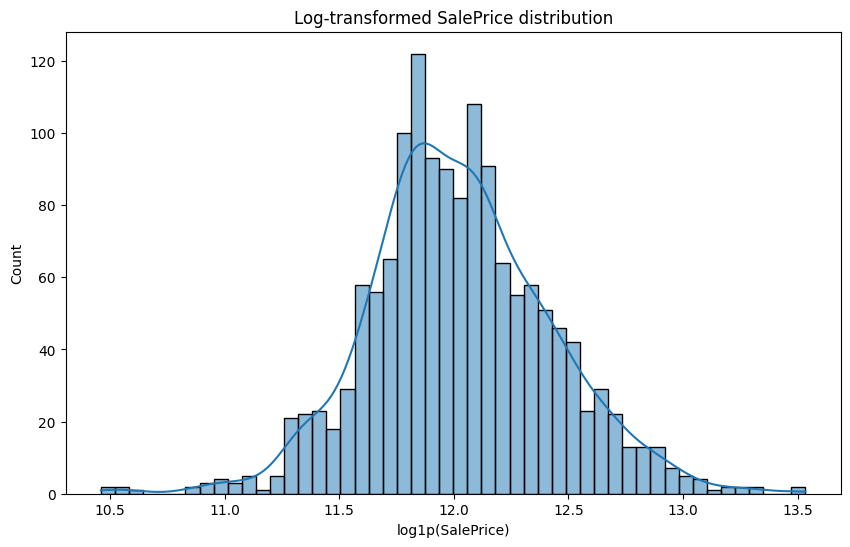

First 5 rows of Dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Dataframe Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   i

None


Description of Numeric columns:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.06620

<Figure size 1400x600 with 0 Axes>

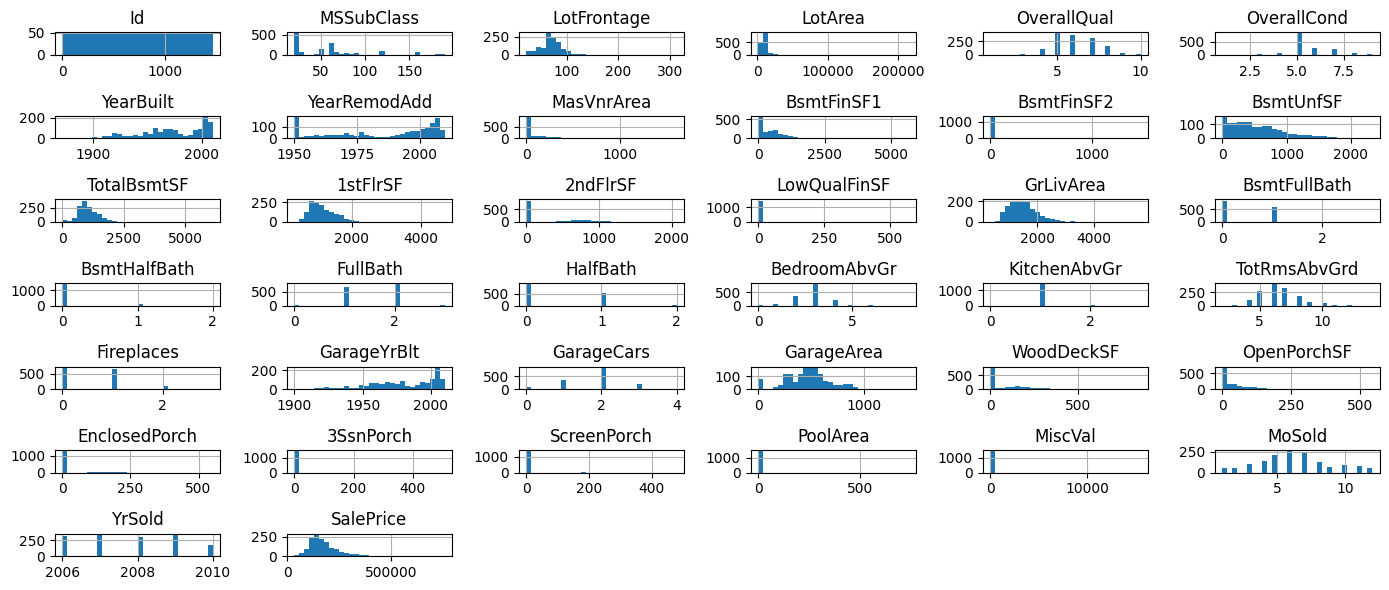

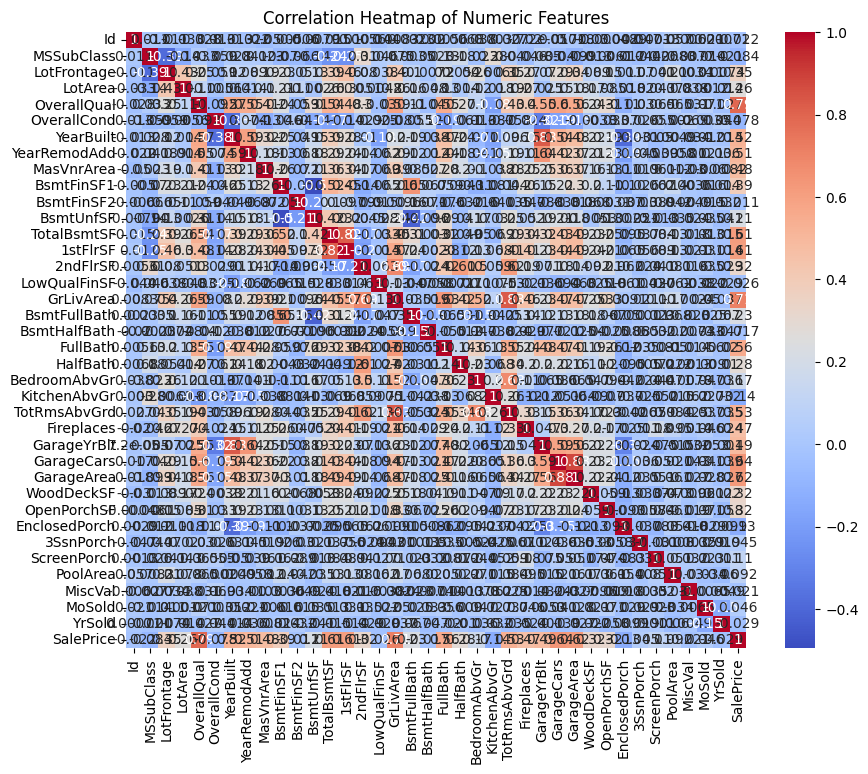

In [69]:
# --- Step 2: Initial EDA and description ---
# Show basic info, head, and target distribution. Save key plots.
def quick_eda(df):
    print("\n=== Quick EDA ===")
    display_cols = ['Id', 'SalePrice'] if 'SalePrice' in df.columns else df.columns[:5]
    print(df[display_cols].head())
    print("\nData types:")
    print(df.dtypes.value_counts())
    print("\nMissing values (top 20):")
    print(df.isnull().sum().sort_values(ascending=False).head(20))
    print("\nBasic stats for numeric features:")
    print(df.select_dtypes(include=[np.number]).describe().T[['count','mean','std','min','50%','max']].head(10))

# run quick EDA
quick_eda(train)

# Plot SalePrice distribution
plt.figure(figsize=(10,6))
sns.histplot(train['SalePrice'], kde=True, bins=50)
plt.title('SalePrice distribution')
plt.xlabel('SalePrice')
plt.savefig(PLOTS_DIR / "saleprice_distribution.png", bbox_inches='tight')
plt.show()


# SalePrice is usually right-skewed; log-transform can help for regression.
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(train['SalePrice']), kde=True, bins=50)
plt.title('Log-transformed SalePrice distribution')
plt.xlabel('log1p(SalePrice)')
plt.savefig(PLOTS_DIR / "saleprice_log_distribution.png", bbox_inches='tight')
plt.show()

df = train.copy()

###############

print("First 5 rows of Dataset:")
display(df.head()) # default 5

# 1.3 Quick Summary of the dataset Columns
print("\nDataframe Columns:")
display(df.info())

# 1.4 Describe numeric columns, Min, 25%, 50%, 75%, Max values
print("\nDescription of Numeric columns:")
print(df.describe())

# 1.5 Look for missing values and duplicates
missing_counts = df.isna().sum()
duplicate_counts = df.duplicated().sum()
print("\nMissing values per column:")
print(missing_counts)
print("\nDuplicate values in Dataframe:")
print(f"{duplicate_counts}  Duplicate(s)\n")

# 1.6 Optional: Visual exploration
#       - Histograms or boxplots for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# You might also want to check if these columns are actually numeric dtype
# For safety, let's convert them if they are stored as strings.
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

plt.figure(figsize=(14, 6))
df[numeric_cols].hist(bins=30, figsize=(14, 6))
plt.tight_layout()
plt.show()

# 1.7 Optional: Correlation matrix for numeric columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8)) # Makes the heatmap figure 10 inches by 8 inches
sns.heatmap(corr, annot=True, cmap='coolwarm')
# annot: shows correlation values inside the heatmap cells.
# cmap='coolwarm': Uses a red-to-blue colormap for visual distinction
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 🚀 Step **3** Feature Engineering

3.1 Create Three(3) New Features

In [70]:
# --- Step 3: Feature engineering (shared features) ---
# We'll create a set of engineered features to improve both tasks.
# We'll operate on a copy of the dataset to keep the original intact.

df = train.copy()

# 3.1 TotalBathrooms
df['TotalBathrooms'] = (
    df.get('FullBath', 0).fillna(0) +
    0.5 * df.get('HalfBath', 0).fillna(0) +
    df.get('BsmtFullBath', 0).fillna(0) +
    0.5 * df.get('BsmtHalfBath', 0).fillna(0)
)

###
drop_cols = ['Id']
df = df.drop(columns=drop_cols)

# Build lists AFTER dropping
NUMERIC_FEATURES = df.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()

# If SalePrice or OverallQual were removed from numeric list:
for x in ['SalePrice', 'OverallQual']:
    if x in NUMERIC_FEATURES:
        NUMERIC_FEATURES.remove(x)
###

# 3.2 HouseAge and YearsSinceRemodel
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']

# 3.3 TotalPorchSF
df['TotalPorchSF'] = df.get('OpenPorchSF', 0).fillna(0) + df.get('EnclosedPorch',0).fillna(0) + df.get('3SsnPorch',0).fillna(0) + df.get('ScreenPorch',0).fillna(0)

# 3.4 TotalFinishedBsmt
df['TotalFinishedBsmt'] = df.get('BsmtFinSF1',0).fillna(0) + df.get('BsmtFinSF2',0).fillna(0)

# 3.5 LivingLotRatio
# avoid division by zero
df['LivingLotRatio'] = df['GrLivArea'] / df['LotArea'].replace({0: np.nan})
df['LivingLotRatio'] = df['LivingLotRatio'].fillna(0)

# 3.6 TotalSquareFeet (aggregate)
df['TotalSF'] = df.get('GrLivArea',0).fillna(0) + df.get('TotalBsmtSF',0).fillna(0) + df.get('GarageArea',0).fillna(0)

# 3.7 TotalRooms (a reinforced feature)
df['TotalRooms'] = df.get('TotRmsAbvGrd',0).fillna(0)

# 3.8 Binary flags for presence of features
df['HasPool'] = (df.get('PoolArea',0) > 0).astype(int)
df['HasGarage'] = (~df['GarageType'].isnull()).astype(int)
df['HasFireplace'] = (df.get('Fireplaces',0) > 0).astype(int)
df['HasBasement'] = (~df['TotalBsmtSF'].isnull() & (df.get('TotalBsmtSF',0) > 0)).astype(int)

# 3.9 Create classification target QualityCategory (Low/Medium/High)
def quality_to_category(q):
    if q <= 4: return 'Low'
    elif q <= 7: return 'Medium'
    else: return 'High'

df['QualityCategory'] = df['OverallQual'].apply(quality_to_category)
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

print("\nEngineered features added. Example:")
print(df[['TotalBathrooms','HouseAge','YearsSinceRemodel','TotalPorchSF','TotalFinishedBsmt','LivingLotRatio','TotalSF','HasPool','QualityCategory']].head())



Engineered features added. Example:
   TotalBathrooms  HouseAge  YearsSinceRemodel  TotalPorchSF  \
0             3.5         5                  5            61   
1             2.5        31                 31             0   
2             3.5         7                  6            42   
3             2.0        91                 36           307   
4             3.5         8                  8            84   

   TotalFinishedBsmt  LivingLotRatio  TotalSF  HasPool QualityCategory  
0                706        0.202367     3114        0          Medium  
1                978        0.131458     2984        0          Medium  
2                486        0.158756     3314        0          Medium  
3                216        0.179791     3115        0          Medium  
4                655        0.154137     4179        0            High  


# 🚀 Step **4**: Step 4: Select features to use (drop obviously useless columns)”

We will drop Id, and for classification we must NOT include SalePrice as a feature.
Also drop columns that are identifiers or leak the target (if any).

Keep a conservative list of features: use most numeric features + selected categorical columns.

We will automatically select:
 - numeric columns (except 'Id', 'SalePrice', 'OverallQual', 'QualityCategory')
 - categorical columns (object or category dtype)
This keeps the pipeline general and avoids hand-dropping important features.



Number of numeric features selected: 47
Number of categorical features selected: 44
Sample numeric features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
Sample categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl']


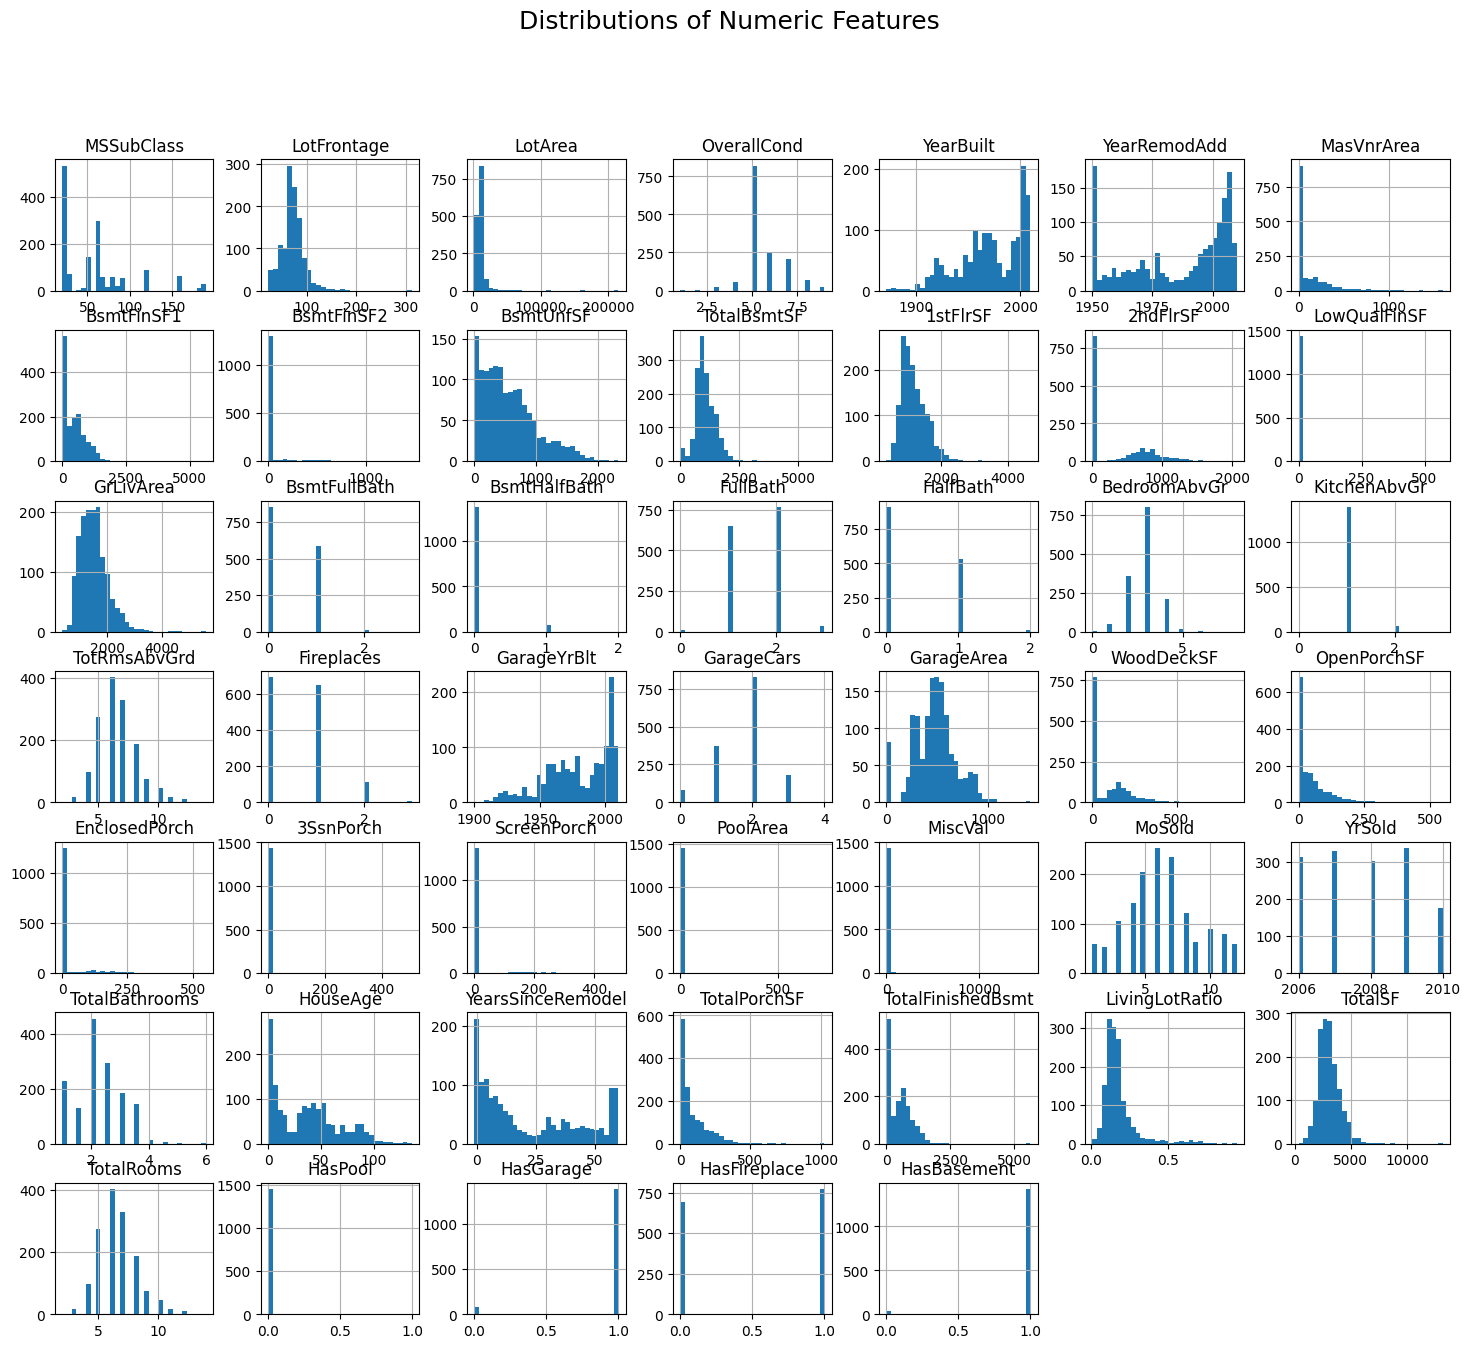

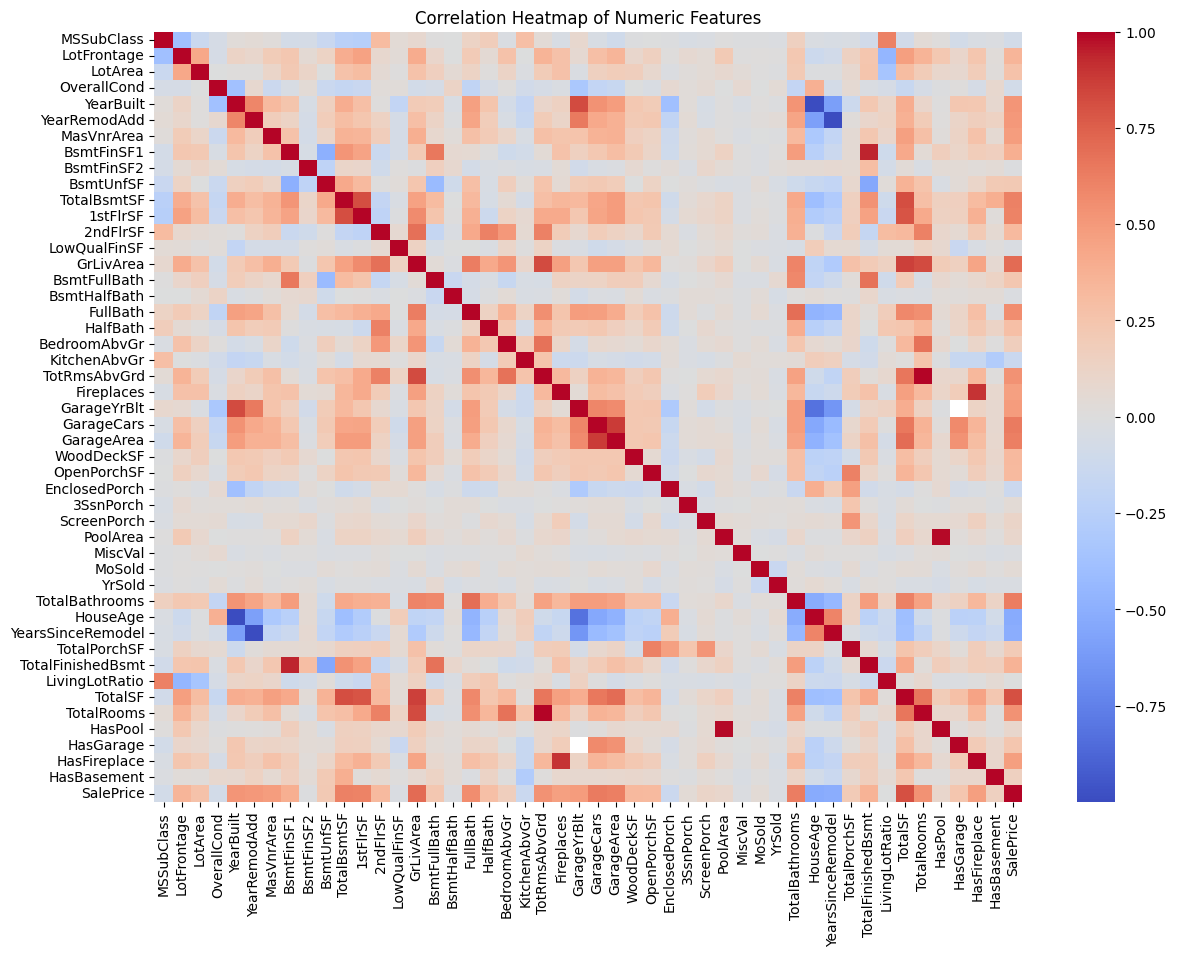

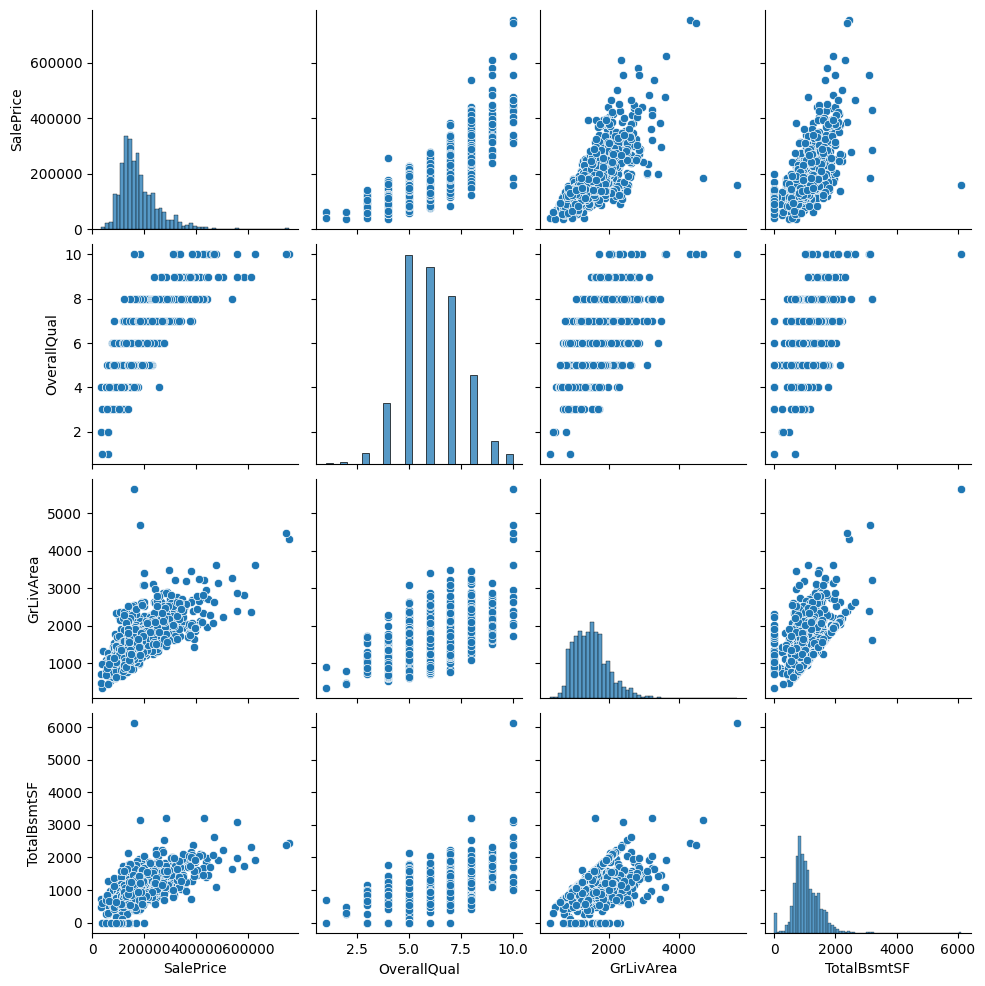

In [71]:
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])  # drop identifier
all_cols = df.columns.tolist()

# numeric features (excluding target)
numeric_feats = df.select_dtypes(include=[np.number]).columns.tolist()
for x in ['SalePrice', 'OverallQual']:
    if x in numeric_feats:
        numeric_feats.remove(x)
# exclude QualityCategory (it's not numeric), ensure YrSold etc included
# categorical features
categorical_feats = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumber of numeric features selected: {len(numeric_feats)}")
print(f"Number of categorical features selected: {len(categorical_feats)}")
print("Sample numeric features:", numeric_feats[:10])
print("Sample categorical features:", categorical_feats[:15])

# We'll construct preprocessing pipelines below that use these lists.
NUMERIC_FEATURES = numeric_feats
CATEGORICAL_FEATURES = categorical_feats


####
# 1. Histograms of numeric features
df[NUMERIC_FEATURES].hist(figsize=(18, 15), bins=30)
plt.suptitle("Distributions of Numeric Features", fontsize=18)
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df[NUMERIC_FEATURES + ['SalePrice']].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 3. (Optional) Small pairplot
important_feats = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF']
sns.pairplot(df[important_feats])
plt.show()





# 🚀 Step **5**: Preprocessing pipelines

In [72]:
# --- Step 5: Preprocessing pipelines ---
# We create sklearn ColumnTransformer pipelines to:
#  - impute numeric features with median and optionally scale for linear models
#  - impute categorical features with constant 'Missing' and one-hot encode, ignore unknowns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # scaling will be applied inside a model-specific pipeline when needed (for LR)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, NUMERIC_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
], remainder='drop')  # drop anything else not specified


# 🚀 Step **6**: Prepare data for Regression (SalePrice)



### We'll use log1p(SalePrice) to stabilize variance and improve linear regression.

In [73]:
# Step 6: Prepare data for Regression (SalePrice)
# We'll use log1p(SalePrice) to stabilize variance and improve linear regression.

reg_df = df.copy()
reg_df = reg_df.drop(columns=drop_cols, errors='ignore')
y_reg = np.log1p(df['SalePrice'])  # log target
X_reg = reg_df.drop(columns=['SalePrice'], errors='ignore')  # keep overallqual as predictor

# split
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print(f"\nRegression dataset shapes: X_train {X_train_reg.shape}, X_val {X_val_reg.shape}")



Regression dataset shapes: X_train (1168, 92), X_val (292, 92)


# 🚀 Step **7**: Regression model pipelines and training
##### We build three pipelines:
#####  - LinearRegression (needs scaling)
#####  - RandomForestRegressor (tree model, no scaling)
#####  - GradientBoostingRegressor (tree model)
#####
##### Each pipeline uses the preprocessor; for LR we'll add a StandardScaler after numeric imputer.

### a. Linear Regression pipeline

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 7.1 Linear Regression pipeline
preprocessor_lr = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), NUMERIC_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
], remainder='drop')

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('lr', LinearRegression())
])


### b. GradientRandom Forest pipeline

In [75]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42))
])

### c. Gradient Boosting pipeline

In [76]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42))
])

### d. Train models

In [77]:
# # # 1. create new engineered feature
# # df['QualityCategory'] = df['OverallQual'].apply(quality_to_category)

# # # 2. drop Id
# # # df = df.drop(columns=['Id'])

# # # 3. split target and predictors
# # X = df.drop('SalePrice', axis=1)
# # y = df['SalePrice']

# # 4. NOW rebuild feature lists
# # NUMERIC_FEATURES = X.select_dtypes(include=[np.number]).columns.tolist()
# # CATEGORICAL_FEATURES = X.select_dtypes(include=['object']).columns.tolist()

# NUMERIC_FEATURES = X_reg.select_dtypes(include=[np.number]).columns.tolist()
# CATEGORICAL_FEATURES = X_reg.select_dtypes(include=['object']).columns.tolist()

# # (remove OverallQual from numeric if needed)
# if 'OverallQual' in NUMERIC_FEATURES:
#     NUMERIC_FEATURES.remove('OverallQual')

# # 5. Train-test split

# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# print("QualityCategory in X_train_reg?", 'QualityCategory' in X_train_reg.columns)


In [78]:

print("\nTraining Linear Regression...")
lr_pipeline.fit(X_train_reg, y_train_reg)

print("Training Random Forest Regressor...")
rf_pipeline.fit(X_train_reg, y_train_reg)

print("Training Gradient Boosting Regressor...")
gb_pipeline.fit(X_train_reg, y_train_reg)



Training Linear Regression...
Training Random Forest Regressor...
Training Gradient Boosting Regressor...


,steps,"[('preprocessor', ...), ('gb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### e. Evaluate on validation set

In [79]:
# Evaluate on validation set
def evaluate_regression(model, X_val, y_val, label="model"):
    preds_log = model.predict(X_val)
    # preds are log1p, so convert back for RMSE on original SalePrice
    preds = np.expm1(preds_log)
    y_true = np.expm1(y_val)
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    return rmse, r2, preds, y_true

lr_rmse, lr_r2, lr_preds, y_true_reg = evaluate_regression(lr_pipeline, X_val_reg, y_val_reg, "LinearRegression")
rf_rmse, rf_r2, rf_preds, _ = evaluate_regression(rf_pipeline, X_val_reg, y_val_reg, "RandomForest")
gb_rmse, gb_r2, gb_preds, _ = evaluate_regression(gb_pipeline, X_val_reg, y_val_reg, "GradientBoosting")

results_reg = pd.DataFrame({
    'model': ['LinearRegression','RandomForest','GradientBoosting'],
    'rmse': [lr_rmse, rf_rmse, gb_rmse],
    'r2': [lr_r2, rf_r2, gb_r2]
}).sort_values('rmse')

print("\nRegression results on validation set:")
print(results_reg)


Regression results on validation set:
              model          rmse        r2
0  LinearRegression  24410.007393  0.922318
2  GradientBoosting  30310.547233  0.880223
1      RandomForest  33767.699452  0.851342


### f. Save regression models

In [80]:
joblib.dump(lr_pipeline, MODELS_DIR / "lr_pipeline_reg.pkl")
joblib.dump(rf_pipeline, MODELS_DIR / "rf_pipeline_reg.pkl")
joblib.dump(gb_pipeline, MODELS_DIR / "gb_pipeline_reg.pkl")

['outputs/models/gb_pipeline_reg.pkl']

### g. Plot Predicted vs Actual (for best model by rmse)

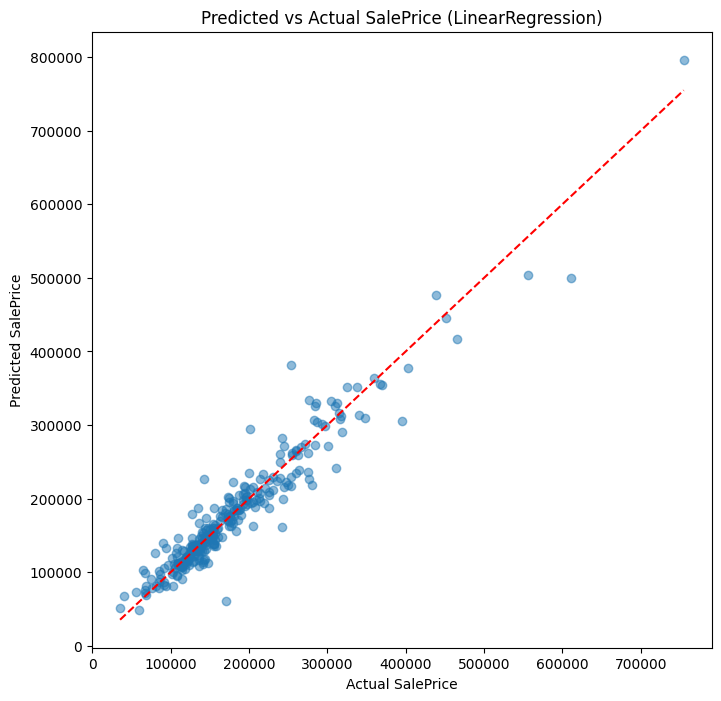

In [81]:
best_reg_model_name = results_reg.iloc[0]['model']
best_reg_preds = {'LinearRegression': lr_preds, 'RandomForest': rf_preds, 'GradientBoosting': gb_preds}[best_reg_model_name]
plt.figure(figsize=(8,8))
plt.scatter(y_true_reg, best_reg_preds, alpha=0.5)
plt.plot([y_true_reg.min(), y_true_reg.max()], [y_true_reg.min(), y_true_reg.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title(f'Predicted vs Actual SalePrice ({best_reg_model_name})')
plt.savefig(PLOTS_DIR / f"pred_vs_actual_{best_reg_model_name}.png", bbox_inches='tight')
plt.show()

### h. Feature importances for tree models (RandomForest & GradientBoosting)

In [82]:
def get_feature_names_from_preprocessor(preprocessor_obj):
    # numeric feature names remain the same
    num_names = NUMERIC_FEATURES
    # get onehot names from the categorical transformer
    cat_pipe = preprocessor_obj.named_transformers_['cat']
    ohe = cat_pipe.named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names_out(CATEGORICAL_FEATURES))
    return num_names + ohe_feature_names

### I. For rf_pipeline: get importances, Fit the preprocessor alone on full training to retrieve feature names

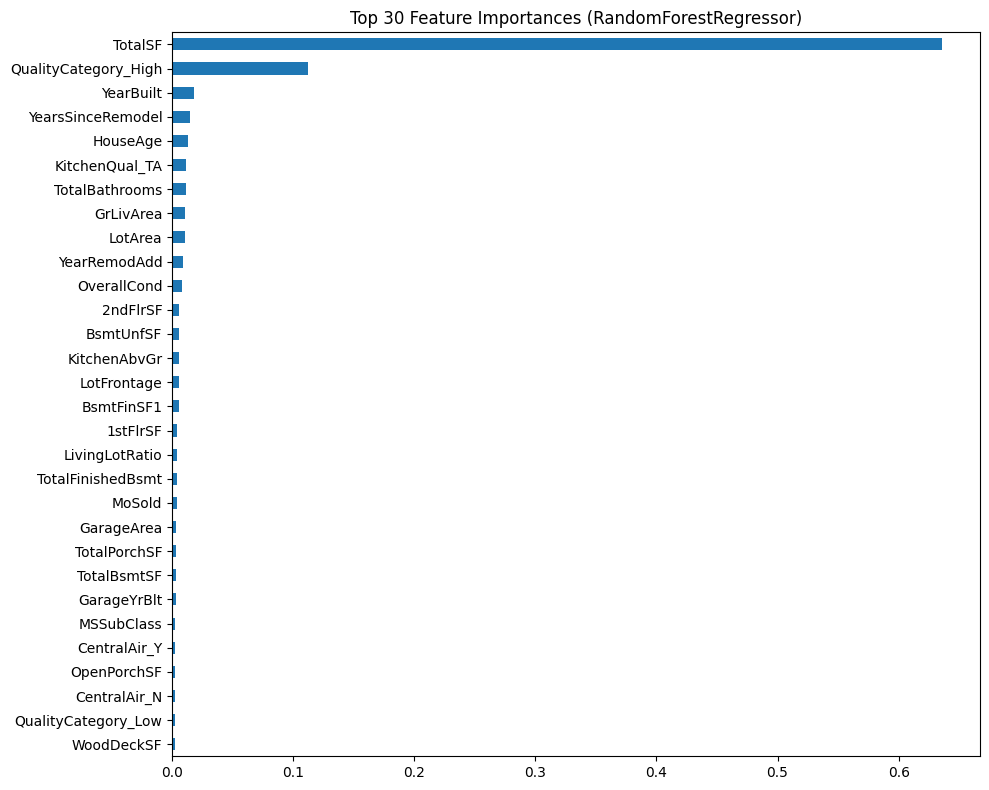

In [83]:
try:
    # Fit the preprocessor alone on full training to retrieve feature names
    preprocessor.fit(X_train_reg)
    feature_names = get_feature_names_from_preprocessor(preprocessor)
    rf_feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    fi_rf = pd.Series(rf_feature_importances, index=feature_names).sort_values(ascending=False)[:30]
    plt.figure(figsize=(10,8))
    fi_rf.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("Top 30 Feature Importances (RandomForestRegressor)")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "rf_feature_importances_reg.png", bbox_inches='tight')
    plt.show()
except Exception as e:
    print("Could not compute or plot feature importances for regression RF:", e)

# 🚀 Step **8**: Prepare data for Classification (QualityCategory)
##### We'll classify 'QualityCategory' into: Low / Medium / High as strings.

In [84]:
# Classify 'QualityCategory' into Low/Medium/High.
cls_df = df.copy()
cls_df = cls_df.drop(columns=drop_cols, errors='ignore')

# Ensure we DO NOT include SalePrice or OverallQual as features (OverallQual is target in original scale)
# However, we created QualityCategory from OverallQual; to keep realistic, drop 'OverallQual' to avoid trivial solution.
if 'OverallQual' in cls_df.columns:
    cls_df = cls_df.drop(columns=['OverallQual'])

# If 'SalePrice' exists, drop it to avoid leakage
if 'SalePrice' in cls_df.columns:
    cls_df = cls_df.drop(columns=['SalePrice'])

# Target
y_cls = cls_df['QualityCategory']
X_cls = cls_df.drop(columns=['QualityCategory'])

# Split
X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print(f"\nClassification dataset shapes: X_train {X_train_cls.shape}, X_val {X_val_cls.shape}")
print("Class distribution in training set:")
print(y_train_cls.value_counts(normalize=True))


Classification dataset shapes: X_train (1168, 90), X_val (292, 90)
Class distribution in training set:
QualityCategory
Medium    0.746575
High      0.156678
Low       0.096747
Name: proportion, dtype: float64


# 🚀 Step **9**: Classification preprocessing & pipelines
##### We reuse the earlier preprocessor objects (numeric transformer + categorical transformer)
##### For classification models we can use the same `preprocessor` defined earlier.

In [85]:
# We rebuild numeric and categorical features specifically for classification,
# after dropping the target 'QualityCategory'
NUMERIC_FEATURES_CLS = X_cls.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_FEATURES_CLS = X_cls.select_dtypes(include=['object']).columns.tolist()

print("Numeric features (CLS):", NUMERIC_FEATURES_CLS)
print("Categorical features (CLS):", CATEGORICAL_FEATURES_CLS)


Numeric features (CLS): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalBathrooms', 'HouseAge', 'YearsSinceRemodel', 'TotalPorchSF', 'TotalFinishedBsmt', 'LivingLotRatio', 'TotalSF', 'TotalRooms', 'HasPool', 'HasGarage', 'HasFireplace', 'HasBasement']
Categorical features (CLS): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',

In [86]:
# Rebuild preprocessing pipelines for classification

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric transformer (scale only for Logistic Regression)
numeric_transformer_lr_cls = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer_cls = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformers
preprocessor_lr_cls = ColumnTransformer([
    ('num', numeric_transformer_lr_cls, NUMERIC_FEATURES_CLS),
    ('cat', categorical_transformer_cls, CATEGORICAL_FEATURES_CLS)
])

preprocessor_cls = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), NUMERIC_FEATURES_CLS),  # no scaling
    ('cat', categorical_transformer_cls, CATEGORICAL_FEATURES_CLS)
])

In [87]:
# Build classification pipelines

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor_lr_cls),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

rf_cls_pipeline = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('rf_cls', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))
])

gb_cls_pipeline = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('gb_cls', GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42))
])


In [88]:

# Train classifiers
print("\nTraining Logistic Regression (classification)...")
logreg_pipeline.fit(X_train_cls, y_train_cls)

print("Training Random Forest Classifier...")
rf_cls_pipeline.fit(X_train_cls, y_train_cls)

print("Training Gradient Boosting Classifier...")
gb_cls_pipeline.fit(X_train_cls, y_train_cls)



Training Logistic Regression (classification)...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...


,steps,"[('preprocessor', ...), ('gb_cls', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Classification results on validation set:
                model  accuracy  f1_macro
0  LogisticRegression  0.849315  0.734354
1        RandomForest  0.845890  0.655088
2    GradientBoosting  0.828767  0.649697


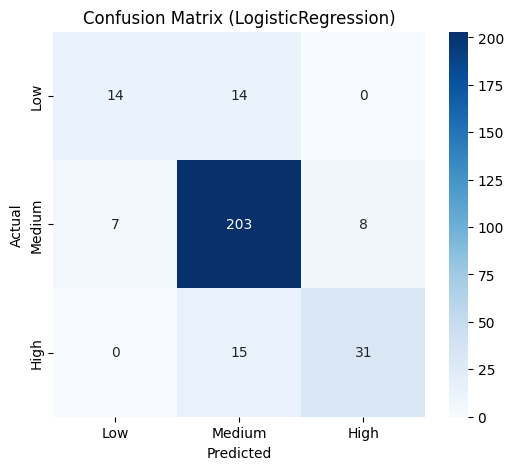


Classification report for best model (LogisticRegression):
              precision    recall  f1-score   support

        High     0.7949    0.6739    0.7294        46
         Low     0.6667    0.5000    0.5714        28
      Medium     0.8750    0.9312    0.9022       218

    accuracy                         0.8493       292
   macro avg     0.7788    0.7017    0.7344       292
weighted avg     0.8424    0.8493    0.8433       292



In [89]:

# Evaluate classification
def evaluate_classification(model, X_val, y_val, label="model"):
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average='macro')
    cm = confusion_matrix(y_val, preds, labels=['Low','Medium','High'])
    return acc, f1, preds, cm

log_acc, log_f1, log_preds, log_cm = evaluate_classification(logreg_pipeline, X_val_cls, y_val_cls, "LogisticRegression")
rf_acc, rf_f1, rf_preds, rf_cm = evaluate_classification(rf_cls_pipeline, X_val_cls, y_val_cls, "RandomForest")
gb_acc, gb_f1, gb_preds, gb_cm = evaluate_classification(gb_cls_pipeline, X_val_cls, y_val_cls, "GradientBoosting")

results_cls = pd.DataFrame({
    'model': ['LogisticRegression','RandomForest','GradientBoosting'],
    'accuracy': [log_acc, rf_acc, gb_acc],
    'f1_macro': [log_f1, rf_f1, gb_f1]
}).sort_values('accuracy', ascending=False)

print("\nClassification results on validation set:")
print(results_cls)

# Save classification models
joblib.dump(logreg_pipeline, MODELS_DIR / "logreg_pipeline_cls.pkl")
joblib.dump(rf_cls_pipeline, MODELS_DIR / "rf_pipeline_cls.pkl")
joblib.dump(gb_cls_pipeline, MODELS_DIR / "gb_pipeline_cls.pkl")


# Plot confusion matrix for best classifier
best_cls_model_name = results_cls.iloc[0]['model']
best_cm = {'LogisticRegression': log_cm, 'RandomForest': rf_cm, 'GradientBoosting': gb_cm}[best_cls_model_name]
plt.figure(figsize=(6,5))
sns.heatmap(best_cm, annot=True, fmt='d', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ({best_cls_model_name})')
plt.savefig(PLOTS_DIR / f"confusion_matrix_{best_cls_model_name}.png", bbox_inches='tight')
plt.show()

# Print classification report for the best classifier
best_preds = {'LogisticRegression': log_preds, 'RandomForest': rf_preds, 'GradientBoosting': gb_preds}[best_cls_model_name]
print(f"\nClassification report for best model ({best_cls_model_name}):")
print(classification_report(y_val_cls, best_preds, digits=4))


# # Feature importance for RF classifier (top features)
# try:
#     preprocessor.fit(X_train_cls)
#     feature_names = get_feature_names_from_preprocessor(preprocessor)
#     rf_cls_feature_importances = rf_cls_pipeline.named_steps['rf_cls'].feature_importances_
#     fi_rf_cls = pd.Series(rf_cls_feature_importances, index=feature_names).sort_values(ascending=False)[:30]
#     plt.figure(figsize=(10,8))
#     fi_rf_cls.plot(kind='barh')
#     plt.gca().invert_yaxis()
#     plt.title("Top 30 Feature Importances (RandomForestClassifier)")
#     plt.tight_layout()
#     plt.savefig(PLOTS_DIR / "rf_feature_importances_cls.png", bbox_inches='tight')
#     plt.show()
# except Exception as e:
#     print("Could not compute or plot feature importances for classification RF:", e)


In [90]:
# # Ensure the 'OverallQual' column is in the original dataset
# print("Columns in original train dataset:")
# print(train.columns)

# # Check that 'OverallQual' is in the features (X) before the split
# features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
#             'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
#             'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
#             'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
#             'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
#             'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
#             'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
#             'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
#             '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
#             'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
#             'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
#             'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
#             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
#             'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
#             'SaleCondition', 'TotalBathrooms', 'HouseAge', 'YearsSinceRemodel', 'TotalPorchSF',
#             'TotalFinishedBsmt', 'LivingLotRatio', 'TotalSF', 'TotalRooms', 'HasPool', 'HasGarage',
#             'HasFireplace', 'HasBasement']

# # Split the data (ensure 'OverallQual' is in X_train_cls)
# X = train[features]  # Make sure 'OverallQual' is in this list
# y = train['SalePrice']  # Assuming SalePrice is the target variable

# # Now, let's split into training and validation sets
# from sklearn.model_selection import train_test_split
# X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# # Check if 'OverallQual' is in X_train_cls
# print("Columns in X_train_cls after splitting:")
# print(X_train_cls.columns)


# 🚀 Step **10**: Compare feature importance and insights
##### Simple side-by-side summary output saved to file

In [91]:
summary = {
    'regression_results': results_reg.to_dict(orient='records'),
    'classification_results': results_cls.to_dict(orient='records'),
    'best_regression_model': best_reg_model_name,
    'best_classification_model': best_cls_model_name
}

import json
with open(OUTPUT_DIR / "summary_results.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSummary saved to outputs/summary_results.json")
print("Plots saved to outputs/plots/ and models saved to outputs/models/")



Summary saved to outputs/summary_results.json
Plots saved to outputs/plots/ and models saved to outputs/models/


# 🚀 Step **11**: Prepare test.csv predictions for submission
##### If a test.csv is available and it lacks SalePrice, We could produce predictions using your best regression model.

In [92]:
# --- Step 11: (Optional) Prepare test.csv predictions for submission ---
# If a test.csv is available and it lacks SalePrice (typical Kaggle setup),
# you could produce predictions using your best regression model.
if test is not None:
    print("\nPreparing predictions for test.csv (if columns match).")
    # apply same engineered features on test copy
    test_copy = test.copy()

    # Recreate engineered features safely (same as done for training set)
    test_copy['TotalBathrooms'] = (
        test_copy.get('FullBath', 0).fillna(0) +
        0.5 * test_copy.get('HalfBath', 0).fillna(0) +
        test_copy.get('BsmtFullBath', 0).fillna(0) +
        0.5 * test_copy.get('BsmtHalfBath', 0).fillna(0)
    )
    test_copy['HouseAge'] = test_copy['YrSold'] - test_copy['YearBuilt']
    test_copy['YearsSinceRemodel'] = test_copy['YrSold'] - test_copy['YearRemodAdd']
    test_copy['TotalPorchSF'] = test_copy.get('OpenPorchSF', 0).fillna(0) + test_copy.get('EnclosedPorch', 0).fillna(0) + test_copy.get('3SsnPorch', 0).fillna(0) + test_copy.get('ScreenPorch', 0).fillna(0)
    test_copy['TotalFinishedBsmt'] = test_copy.get('BsmtFinSF1', 0).fillna(0) + test_copy.get('BsmtFinSF2', 0).fillna(0)
    test_copy['LivingLotRatio'] = test_copy['GrLivArea'] / test_copy['LotArea'].replace({0: np.nan})
    test_copy['LivingLotRatio'] = test_copy['LivingLotRatio'].fillna(0)
    test_copy['TotalSF'] = test_copy.get('GrLivArea', 0).fillna(0) + test_copy.get('TotalBsmtSF', 0).fillna(0) + test_copy.get('GarageArea', 0).fillna(0)
    test_copy['TotalRooms'] = test_copy.get('TotRmsAbvGrd', 0).fillna(0)
    test_copy['HasPool'] = (test_copy.get('PoolArea', 0) > 0).astype(int)
    test_copy['HasGarage'] = (~test_copy['GarageType'].isnull()).astype(int)
    test_copy['HasFireplace'] = (test_copy.get('Fireplaces', 0) > 0).astype(int)
    test_copy['HasBasement'] = (~test_copy['TotalBsmtSF'].isnull() & (test_copy.get('TotalBsmtSF', 0) > 0)).astype(int)

    # Check if 'QualityCategory' is missing in test data and create it if necessary
    if 'QualityCategory' not in test_copy.columns:
        test_copy['QualityCategory'] = test_copy['OverallQual'].apply(quality_to_category)

    # Ensure same columns exist - drop columns not present in training set
    # We'll attempt to predict with the best regression model
    model_for_submission = {'LinearRegression': lr_pipeline, 'RandomForest': rf_pipeline, 'GradientBoosting': gb_pipeline}[best_reg_model_name]
    try:
        preds_log_test = model_for_submission.predict(test_copy)
        preds_test = np.expm1(preds_log_test)
        submission = pd.DataFrame({
            'Id': test_copy['Id'],
            'SalePrice': preds_test
        })
        submission.to_csv(OUTPUT_DIR / "submission_example.csv", index=False)
        print("Example submission saved to outputs/submission_example.csv")
    except Exception as e:
        print("Could not produce test predictions automatically. Error:", e)



Preparing predictions for test.csv (if columns match).
Example submission saved to outputs/submission_example.csv


### Step 12: Final notes and tips


In [93]:
print("\n--- Final Notes ---")
print("1) Best regression model (by RMSE):", best_reg_model_name)
print("2) Best classification model (by accuracy):", best_cls_model_name)
print("3) Check outputs/plots for all visualizations and outputs/models for saved model pipelines.")
print("\nImprovements:")
print("- add hyperparameter tuning (GridSearchCV/RandomizedSearchCV),")
print("- add SHAP explanations for feature impact (if you want interpretability).\n")
print("Run completed at:", datetime.now().isoformat())


--- Final Notes ---
1) Best regression model (by RMSE): LinearRegression
2) Best classification model (by accuracy): LogisticRegression
3) Check outputs/plots for all visualizations and outputs/models for saved model pipelines.

Improvements:
- add hyperparameter tuning (GridSearchCV/RandomizedSearchCV),
- add SHAP explanations for feature impact (if you want interpretability).

Run completed at: 2025-12-05T00:40:05.234099


## 🚀 Step **13**: — Interactive CLI-style Prediction (No DB, no extra files)

##### This section prompts for a one-line record (key=value, key=value, …), computes engineered features, and produces:
#####  - Predicted SalePrice (USD) from the regression pipeline (converts from log1p)
#####  - Predicted QualityCategory from the classification pipeline, with optional probabilities

##### It will use in-memory models if they exist (from earlier cells). If not found, it will try to load `lr_pipeline_reg.pkl` and `logreg_pipeline_cls.pkl` from the current working directory.

In [108]:
# Section 13.1 — Setup and Helpers (Colab-friendly, robust to missing fields and TTR)

import re
import inspect
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- Parse a one-line input of key=value pairs ----------
def parse_record_line(line: str) -> dict:
    # Split on commas but preserve quoted values
    parts = re.findall(r'(?:[^,"]+|"[^"]*")+', str(line))
    rec = {}
    for part in parts:
        if '=' not in part:
            continue
        k, v = part.split('=', 1)
        key = k.strip()
        val = v.strip().strip('"').strip("'")
        # numeric cast if possible
        try:
            if re.fullmatch(r'[-+]?\d+', val):
                val_cast = int(val)
            elif re.fullmatch(r'[-+]?(?:\d*\.\d+|\d+\.\d*)(?:[eE][-+]?\d+)?', val):
                val_cast = float(val)
            else:
                val_cast = val
        except Exception:
            val_cast = val
        rec[key] = val_cast
    return rec

# ---------- Robust feature engineering (always returns Series, never scalars) ----------
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    def s0(col):   # numeric Series default 0
        if col in df.columns:
            return pd.to_numeric(df[col], errors="coerce")
        return pd.Series(0, index=df.index, dtype="float64")

    def sNaN(col): # numeric Series default NaN
        if col in df.columns:
            return pd.to_numeric(df[col], errors="coerce")
        return pd.Series(np.nan, index=df.index, dtype="float64")

    # Bathrooms (missing → 0)
    full_bath = s0("FullBath")
    half_bath = s0("HalfBath")
    bfull = s0("BsmtFullBath")
    bhalf = s0("BsmtHalfBath")
    df["TotalBathrooms"] = full_bath.fillna(0) + 0.5*half_bath.fillna(0) + bfull.fillna(0) + 0.5*bhalf.fillna(0)

    # Ages
    df["HouseAge"] = sNaN("YrSold") - sNaN("YearBuilt")
    df["YearsSinceRemodel"] = sNaN("YrSold") - sNaN("YearRemodAdd")

    # Porches (missing → 0)
    df["TotalPorchSF"] = (
        s0("OpenPorchSF").fillna(0)
        + s0("EnclosedPorch").fillna(0)
        + s0("3SsnPorch").fillna(0)
        + s0("ScreenPorch").fillna(0)
    )

    # Basement finished (missing → 0)
    df["TotalFinishedBsmt"] = s0("BsmtFinSF1").fillna(0) + s0("BsmtFinSF2").fillna(0)

    # Ratios and totals
    lot_area = sNaN("LotArea").replace({0: np.nan})
    df["LivingLotRatio"] = (s0("GrLivArea") / lot_area).replace([np.inf, -np.inf], np.nan).fillna(0)
    df["TotalSF"] = s0("GrLivArea").fillna(0) + s0("TotalBsmtSF").fillna(0)
    df["TotalRooms"] = s0("TotRmsAbvGrd").fillna(0)

    # Binary flags
    df["HasPool"] = (s0("PoolArea").fillna(0) > 0).astype(int)
    if "GarageType" in df.columns:
        gt = df["GarageType"].astype("string")
        df["HasGarage"] = gt.fillna("").str.strip().ne("").astype(int)
    else:
        df["HasGarage"] = ((s0("GarageCars").fillna(0) > 0) | (s0("GarageArea").fillna(0) > 0)).astype(int)
    df["HasFireplace"] = (s0("Fireplaces").fillna(0) > 0).astype(int)
    df["HasBasement"] = (s0("TotalBsmtSF").fillna(0) > 0).astype(int)

    # QualityCategory (used by regression)
    def quality_to_category(val):
        try:
            q = float(val)
        except Exception:
            return np.nan
        if q <= 4:
            return "Low"
        elif q <= 7:
            return "Medium"
        else:
            return "High"

    df["QualityCategory"] = sNaN("OverallQual").apply(quality_to_category)

    # Drop identifiers if present
    if "Id" in df.columns:
        df = df.drop(columns=["Id"])

    return df

# ---------- Introspect expected raw columns from models ----------
def expected_columns_from_models(models):
    cols = set()
    try:
        from sklearn.compose import ColumnTransformer
        from sklearn.compose import TransformedTargetRegressor
    except Exception:
        ColumnTransformer = None
        TransformedTargetRegressor = None

    def add_from_estimator(est):
        # Handle pipelines/column transformers inside
        # 1) Drill into TransformedTargetRegressor to reach inner regressor
        if TransformedTargetRegressor and isinstance(est, TransformedTargetRegressor):
            inner = getattr(est, "regressor", None) or getattr(est, "regressor_", None)
            if inner is not None:
                add_from_estimator(inner)
            return
        # 2) If pipeline-like with named_steps, scan for ColumnTransformer
        for obj in [est] + list(getattr(est, "named_steps", {}).values()):
            if ColumnTransformer and isinstance(obj, ColumnTransformer):
                for name, transformer, columns in obj.transformers:
                    if columns is None or columns == "drop":
                        continue
                    if hasattr(columns, "__iter__") and not isinstance(columns, str):
                        for c in columns:
                            if isinstance(c, str):
                                cols.add(c)
        # 3) Fallbacks
        for obj in [est] + list(getattr(est, "named_steps", {}).values()):
            if hasattr(obj, "feature_names_in_"):
                for c in obj.feature_names_in_:
                    cols.add(str(c))

    for m in models:
        add_from_estimator(m)

    return sorted(cols)

# ---------- Align DataFrame to model-expected columns ----------
def align_columns(df, expected):
    if not expected:
        return df
    out = df.copy()
    for c in expected:
        if c not in out.columns:
            out[c] = np.nan
    return out[expected]

# ---------- Load fitted models safely (no classes, fitted instances only) ----------
def resolve_models(reg_path='lr_pipeline_reg.pkl', cls_path='logreg_pipeline_cls.pkl'):
    import joblib
    reg_model = cls_model = None

    if Path(reg_path).exists():
        reg_model = joblib.load(reg_path)
    if Path(cls_path).exists():
        cls_model = joblib.load(cls_path)

    # Fallback: search for fitted instances in globals (NOT classes)
    def is_fitted_instance(x):
        if inspect.isclass(x):
            return False
        # Must have predict and not be a plain function
        if not hasattr(x, "predict"):
            return False
        # Heuristic: fitted estimators/pipelines often have attributes like n_features_in_, named_steps, classes_, etc.
        return True

    if reg_model is None:
        for name, obj in globals().items():
            if any(tok in name.lower() for tok in ["reg", "price", "lin"]) and is_fitted_instance(obj):
                reg_model = obj
                break

    if cls_model is None:
        for name, obj in globals().items():
            if any(tok in name.lower() for tok in ["cls", "class", "log"]) and is_fitted_instance(obj):
                cls_model = obj
                break

    missing = []
    if reg_model is None:
        missing.append("regression model (lr_pipeline_reg.pkl)")
    if cls_model is None:
        missing.append("classification model (logreg_pipeline_cls.pkl)")
    if missing:
        raise FileNotFoundError(
            "Not found: " + ", ".join(missing) + ". Upload the .pkl files or re-run training to create them in this runtime."
        )
    return reg_model, cls_model

### B. Section 13.2 — One-liner UI (ipywidgets)

In [113]:
# Section 13.2 — Guided one-liner input (A/B/C examples + interpretation)

import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Load models (from pickle or in-memory)
reg_model, cls_model = resolve_models()

# Input guide with examples
guide_html = """
<div style='font-family:Inter,system-ui,Arial;line-height:1.45'>
  <h4>How to enter your house details</h4>
  <ul>
    <li>Type a single line of comma-separated key=value pairs.</li>
    <li>Keys are case-sensitive. Example keys: <code>OverallQual</code>, <code>YearBuilt</code>, <code>GrLivArea</code>, <code>LotArea</code>, <code>FullBath</code>, <code>HalfBath</code>, <code>YrSold</code>, etc.</li>
    <li>Strings with spaces should be quoted: <code>Neighborhood=\"Old Town\"</code>. Unknown categorical values are fine.</li>
    <li>You can omit fields; missing values are imputed. More fields = better accuracy.</li>
  </ul>
  <b>Recommended minimum fields</b>: OverallQual, YearBuilt, YearRemodAdd, YrSold, GrLivArea, TotalBsmtSF, LotArea, FullBath, HalfBath
  <p style="margin-top:8px"><b>Pick an example (A/B/C) or paste your own full one-liner:</b></p>
  <ol>
    <li><b>A — Mid-tier family home</b><br>
      <code>OverallQual=7,YearBuilt=2003,YearRemodAdd=2003,YrSold=2008,GrLivArea=1710,TotalBsmtSF=856,LotArea=8450,FullBath=2,HalfBath=1,TotRmsAbvGrd=8,Fireplaces=0,GarageType=Attchd,GarageCars=2,GarageArea=548,OpenPorchSF=61,EnclosedPorch=0,3SsnPorch=0,ScreenPorch=0,PoolArea=0,KitchenQual=Gd,CentralAir=Y,Neighborhood=CollgCr</code>
    </li>
    <li><b>B — Entry-level basic home</b><br>
      <code>OverallQual=4,YearBuilt=1975,YearRemodAdd=1975,YrSold=2007,GrLivArea=1050,TotalBsmtSF=600,LotArea=7000,FullBath=1,HalfBath=1,TotRmsAbvGrd=5,Fireplaces=0,GarageType=Detchd,GarageCars=1,GarageArea=240,OpenPorchSF=0,EnclosedPorch=0,3SsnPorch=0,ScreenPorch=0,PoolArea=0,KitchenQual=TA,CentralAir=N,Neighborhood=NAmes</code>
    </li>
    <li><b>C — High-end newer home</b><br>
      <code>OverallQual=9,YearBuilt=2006,YearRemodAdd=2007,YrSold=2010,GrLivArea=2600,TotalBsmtSF=1200,LotArea=11000,FullBath=3,HalfBath=1,TotRmsAbvGrd=9,Fireplaces=1,GarageType=Attchd,GarageCars=3,GarageArea=720,OpenPorchSF=120,EnclosedPorch=0,3SsnPorch=0,ScreenPorch=0,PoolArea=0,KitchenQual=Ex,CentralAir=Y,Neighborhood=NridgHt</code>
    </li>
  </ol>
  <p style="margin-top:8px">Type <b>A</b>, <b>B</b>, or <b>C</b> to use an example. Or paste your full one-line input.</p>
</div>
"""
display(HTML(guide_html))

example_A = "OverallQual=7,YearBuilt=2003,YearRemodAdd=2003,YrSold=2008,GrLivArea=1710,TotalBsmtSF=856,LotArea=8450,FullBath=2,HalfBath=1,TotRmsAbvGrd=8,Fireplaces=0,GarageType=Attchd,GarageCars=2,GarageArea=548,OpenPorchSF=61,EnclosedPorch=0,3SsnPorch=0,ScreenPorch=0,PoolArea=0,KitchenQual=Gd,CentralAir=Y,Neighborhood=CollgCr"
example_B = "OverallQual=4,YearBuilt=1975,YearRemodAdd=1975,YrSold=2007,GrLivArea=1050,TotalBsmtSF=600,LotArea=7000,FullBath=1,HalfBath=1,TotRmsAbvGrd=5,Fireplaces=0,GarageType=Detchd,GarageCars=1,GarageArea=240,OpenPorchSF=0,EnclosedPorch=0,3SsnPorch=0,ScreenPorch=0,PoolArea=0,KitchenQual=TA,CentralAir=N,Neighborhood=NAmes"
example_C = "OverallQual=9,YearBuilt=2006,YearRemodAdd=2007,YrSold=2010,GrLivArea=2600,TotalBsmtSF=1200,LotArea=11000,FullBath=3,HalfBath=1,TotRmsAbvGrd=9,Fireplaces=1,GarageType=Attchd,GarageCars=3,GarageArea=720,OpenPorchSF=120,EnclosedPorch=0,3SsnPorch=0,ScreenPorch=0,PoolArea=0,KitchenQual=Ex,CentralAir=Y,Neighborhood=NridgHt"

choice = input("Your choice (A/B/C) OR paste a full one-liner: ").strip()
if choice.upper() == "A":
    line = example_A
elif choice.upper() == "B":
    line = example_B
elif choice.upper() == "C":
    line = example_C
else:
    line = choice

record = parse_record_line(line)
if not record:
    raise ValueError("Could not parse any key=value pairs. Use the examples above or paste a valid one-liner.")

# Light validation messages (not blocking)
def _warns_for(rec: dict):
    w = []
    def iv(k): return rec.get(k, None)
    try:
        oq = iv("OverallQual");
        if oq is not None and not (1 <= float(oq) <= 10): w.append("OverallQual should be 1–10.")
        yb = iv("YearBuilt"); yrm = iv("YearRemodAdd"); ys = iv("YrSold")
        if yb and yrm and float(yrm) < float(yb): w.append("YearRemodAdd < YearBuilt.")
        if yb and ys and float(ys) < float(yb): w.append("YrSold < YearBuilt.")
        gla = iv("GrLivArea");
        if gla is not None and float(gla) < 300: w.append("GrLivArea < 300 sqft (very small).")
        lot = iv("LotArea");
        if lot is not None and float(lot) < 1000: w.append("LotArea < 1000 sqft (very small).")
    except Exception:
        pass
    return w

warns = _warns_for(record)
if warns:
    print("\nNotes about your input:")
    for m in warns:
        print(" -", m)

# Feature engineering + alignment
df_raw = pd.DataFrame([record])
df_eng = engineer_features(df_raw)
expected = expected_columns_from_models([reg_model, cls_model])
df_ready = align_columns(df_eng, expected)

# Predict price (handle TTR vs. plain regressors)
y_pred = reg_model.predict(df_ready)[0]
# If model outputs log values (rare with TTR), convert; else leave as-is
saleprice_usd = float(np.expm1(y_pred)) if (0 < float(y_pred) < 20) else float(y_pred)

# Predict quality + probs
quality_label = str(cls_model.predict(df_ready)[0])
if hasattr(cls_model, "predict_proba"):
    probs = cls_model.predict_proba(df_ready)[0]
    classes = list(getattr(cls_model, "classes_", []))
    probs_text = ", ".join(f"{c}={float(p):.3f}" for c, p in zip(classes, probs))
    maxp = float(np.max(probs))
else:
    probs_text = "N/A"
    maxp = 0.0

confidence_note = (
    "Model is confident in the quality category." if maxp >= 0.80 else
    "Moderate confidence; adjacent classes may also be plausible." if maxp >= 0.60 else
    "Low confidence; inputs may sit between adjacent quality bands."
)

# Present results with interpretation
result_html = f"""
<br/>
<br/>
<h3 style="color:green">Prediction Results</h3>
<div style='font-family:Inter,system-ui,Arial; line-height:1.5; margin-top:8px'>
  <div><b>Predicted SalePrice:</b> ${saleprice_usd:,.2f}</div>
  <div><b>Predicted QualityCategory:</b> {quality_label}</div>
  <div><b>Class probabilities:</b> {probs_text}</div>
  <div style='margin-top:6px'><i>{confidence_note}</i></div>
  <div style='margin-top:10px'>
    <b>How to read this:</b>
    <ul>
      <li>SalePrice is a model estimate in USD; the model learned from historical data and applies those patterns here.</li>
      <li>QualityCategory summarizes perceived quality (Low≈1–4, Medium≈5–7, High≈8–10). Other features can shift the classification.</li>
      <li>Missing fields were imputed; adding optional fields (garage/porch/rooms) typically improves accuracy.</li>
    </ul>
  </div>
</div>
"""
display(HTML(result_html))

Your choice (A/B/C) OR paste a full one-liner: A
